# MiRAC-P
The following example presents the nadir passive microwave radiometer MiRAC-P. The Microwave Radar/Radiometer for Arctic Clouds - passive (MiRAC-P) was installed during ACLOUD and AFLUX. During MOSAiC-ACA, passive microwave observations are conducted by the HATPRO instrument.

More information on MiRAC can be found in [Mech et al. (2019)](https://amt.copernicus.org/articles/12/5019/2019/). If you have questions or if you would like to use the data for a publication, please don't hesitate to get in contact with the dataset authors as stated in the dataset attributes `contact` or `author`.

## Data access
* To analyse the data they first have to be loaded by importing the (AC)³airborne meta data catalogue. To do so the pyac3airborne package has to be installed. More information on how to do that and about the catalog can be found [here](https://github.com/igmk/ac3airborne-intake#ac3airborne-intake-catalogue).

## Get data

In [1]:
import ac3airborne

In [2]:
cat = ac3airborne.get_intake_catalog()
list(cat.P5.MIRAC_P)

['ACLOUD_P5_RF04',
 'ACLOUD_P5_RF05',
 'ACLOUD_P5_RF06',
 'ACLOUD_P5_RF07',
 'ACLOUD_P5_RF08',
 'ACLOUD_P5_RF10',
 'ACLOUD_P5_RF11',
 'ACLOUD_P5_RF13',
 'ACLOUD_P5_RF14',
 'ACLOUD_P5_RF15',
 'ACLOUD_P5_RF16',
 'ACLOUD_P5_RF17',
 'ACLOUD_P5_RF18',
 'ACLOUD_P5_RF19',
 'ACLOUD_P5_RF20',
 'ACLOUD_P5_RF21',
 'ACLOUD_P5_RF22',
 'ACLOUD_P5_RF23',
 'ACLOUD_P5_RF25',
 'AFLUX_P5_RF02',
 'AFLUX_P5_RF03',
 'AFLUX_P5_RF04',
 'AFLUX_P5_RF05',
 'AFLUX_P5_RF06',
 'AFLUX_P5_RF07',
 'AFLUX_P5_RF08',
 'AFLUX_P5_RF09',
 'AFLUX_P5_RF10',
 'AFLUX_P5_RF11',
 'AFLUX_P5_RF12',
 'AFLUX_P5_RF13',
 'AFLUX_P5_RF14',
 'AFLUX_P5_RF15']

```{note}
Have a look at the attributes of the xarray dataset `ds_mirac_p` for all relevant information on the dataset, such as author, contact, or citation information.
```

In [3]:
ds_mirac_p = ds_cth = cat['P5']['MIRAC_P']['ACLOUD_P5_RF05'].to_dask()
ds_mirac_p

<xarray.Dataset>
Dimensions:    (channel: 8, time: 14883)
Coordinates:
  * time       (time) datetime64[ns] 2017-05-25T08:20:32 ... 2017-05-25T12:38:36
  * channel    (channel) int64 0 1 2 3 4 5 6 7
Data variables:
    frequency  (channel) float32 ...
    tb         (time, channel) float32 ...
Attributes: (12/14)
    institution:  Institute of Geophysics and Meteorology (IGM), University o...
    source:       airborne observation
    references:   https://doi.org/10.5194/amt-12-5019-2019
    author:       Nils Risse
    convention:   CF-1.8
    featureType:  trajectory
    ...           ...
    flight_id:    RF05
    title:        MiRAC-P brightness temperature
    instrument:   MiRAC-P: Microwave Radar/radiometer for Arctic Clouds (pass...
    history:      measured onboard Polar 5 during ACLOUD campaign; processed,...
    contact:      n.risse@uni-koeln.de, mario.mech@uni-koeln.de
    created:      2021-07-19

The dataset includes nadir brightness temperatures (`tb`) observed by MiRAC-P at the 183.31 GHz water vapor absorption line (183±0.6, ±1.5, ±2.5, ±3.5, ±5.0, ±7.5 GHz) and two window channels at 243 and 340 GHz.

## Load Polar 5 flight phase information
Polar 5 flights are divided into segments to easily access start and end times of flight patterns. For more information have a look at the respective [github](https://github.com/igmk/flight-phase-separation) repository.

At first we want to load the flight segments of (AC)³airborne

In [4]:
meta = ac3airborne.get_flight_segments()

The following command lists all flight segments into the dictionary `segments`

In [5]:
segments = {s.get("segment_id"): {**s, "flight_id": flight["flight_id"]}
             for platform in meta.values()
             for flight in platform.values()
             for s in flight["segments"]
            }

In this example we want to look at a high-level segment during ACLOUD RF05.

In [6]:
seg = segments["ACLOUD_P5_RF05_hl07"]

Using the start and end times of the segment `ACLOUD_P5_RF05_hl07` stored in `seg`, we slice the MiRAC-P data to the selected flight sections.

In [7]:
ds_mirac_p_sel = ds_mirac_p.sel(time=slice(seg["start"], seg["end"]))

In polar regions, the surface type is helpful for the interpretation of airborne passive microwave observations, especially near the marginal sea ice zone, as generally a higher emissivity is expected over sea ice compared to open ocean. Therefore, we also load AMSR2 sea ice concentration data along the Polar 5 flight track, which is operationally derived by the University of Bremen.

In [8]:
ds_sea_ice = cat['P5']['AMSR2_SIC']['ACLOUD_P5_RF05'].to_dask().sel(
    time=slice(seg["start"], seg["end"]))

## Plots

The flight section during ACLOUD RF05 is flown at about 3 km altitude in west-east direction during a cold-air outbreak event perpendicular to the wind field. Clearly one can identify the roll-cloud structure in the radar reflectivity and the 89 GHz brightness temperature.

In [9]:
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import cm
import numpy as np
plt.style.use("../mplstyle/book")

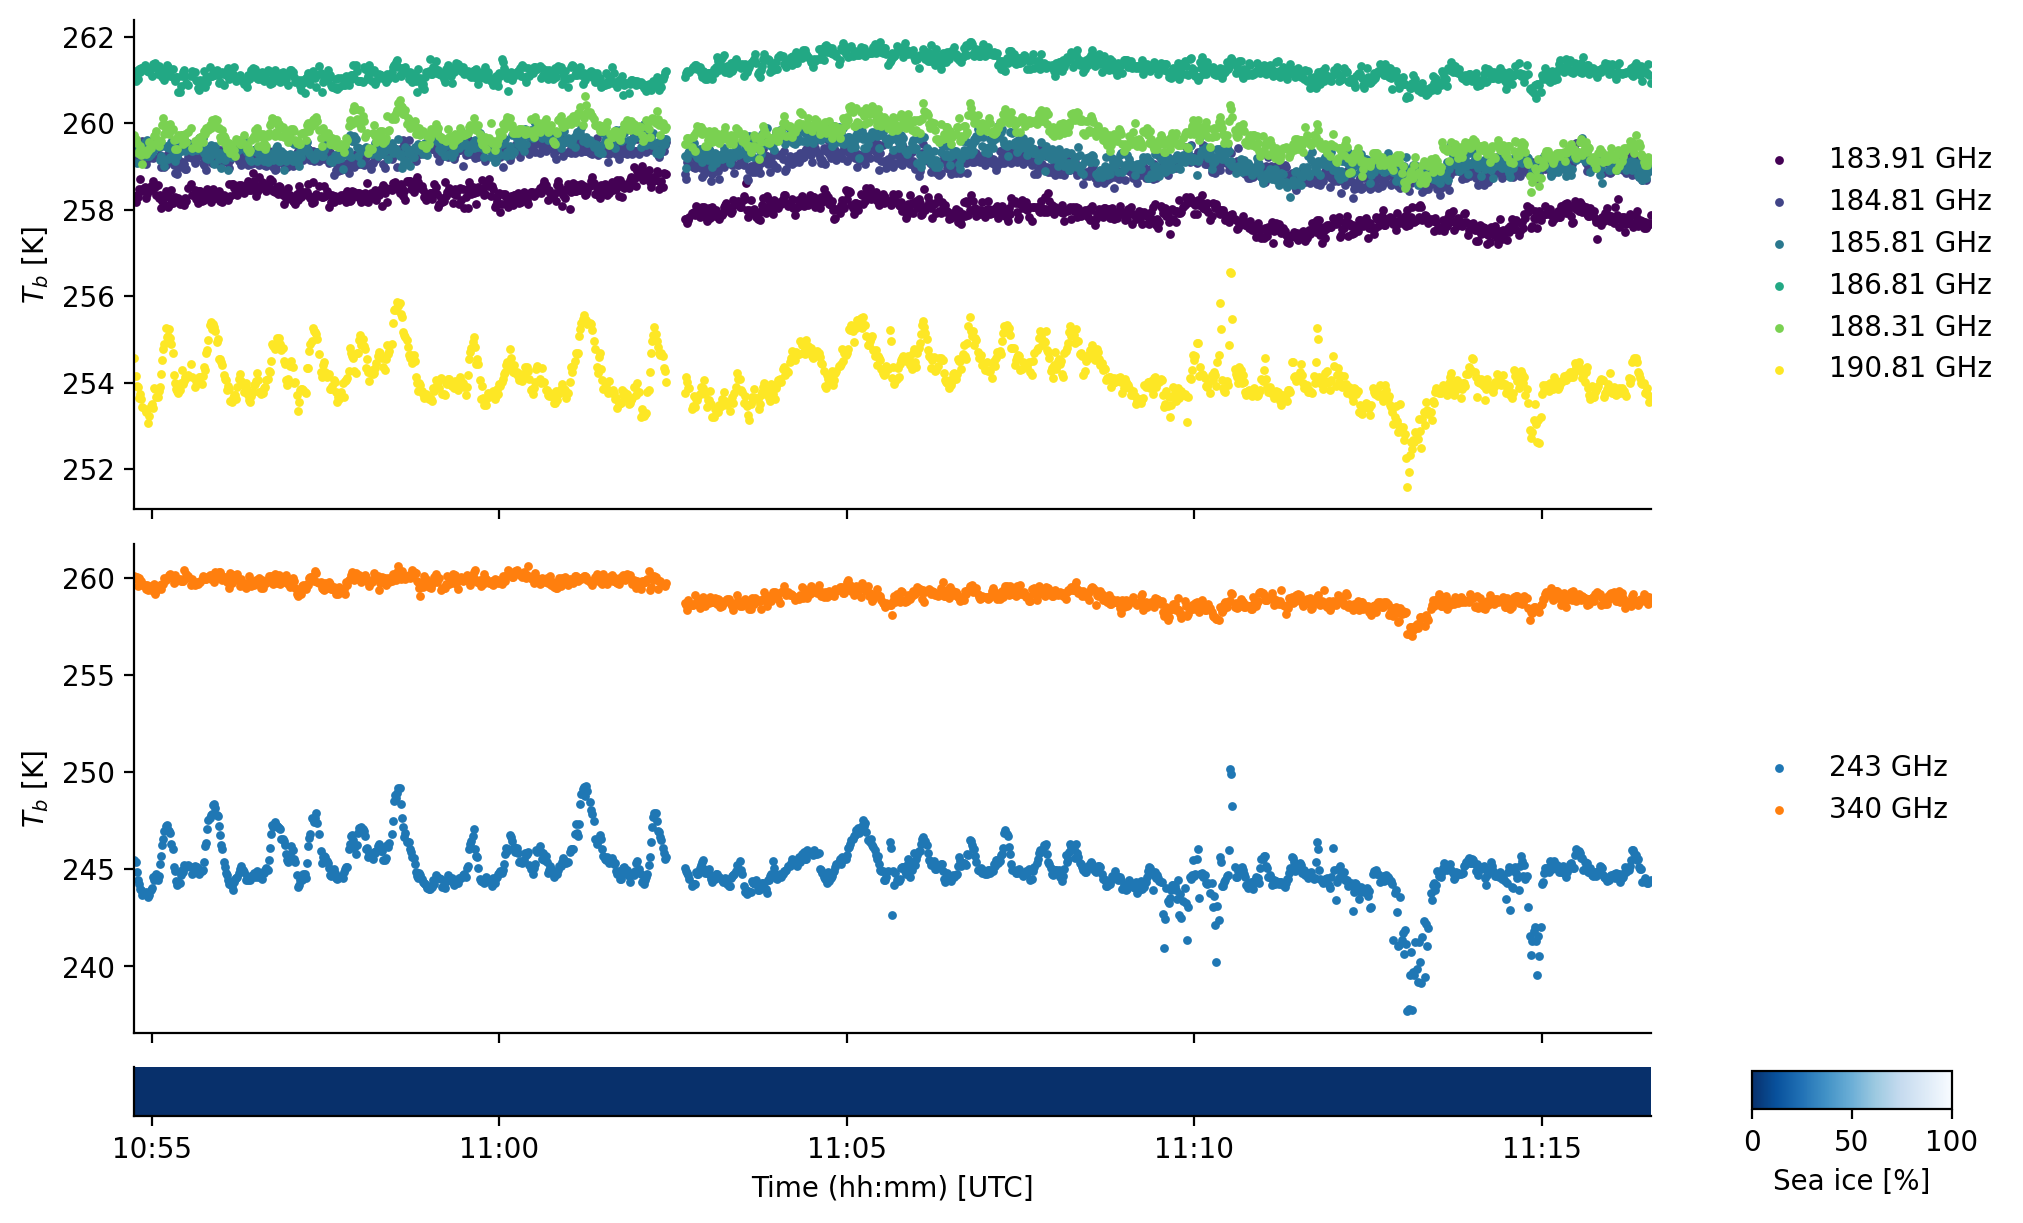

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, gridspec_kw=dict(height_ratios=(1, 1, 0.1)))

kwargs = dict(s=10, linewidths=0)
colors = cm.get_cmap('viridis', 6).colors
for i in range(0, 6):
    ax1.scatter(ds_mirac_p_sel.time, ds_mirac_p_sel.tb.sel(channel=i), label='%g GHz'%ds_mirac_p_sel.frequency.sel(channel=i).item(), color=colors[i], **kwargs)

for i in range(6, 8):
    ax2.scatter(ds_mirac_p_sel.time, ds_mirac_p_sel.tb.sel(channel=i), label='%g GHz'%ds_mirac_p_sel.frequency.sel(channel=i).item(), **kwargs)

ax1.legend(frameon=False, bbox_to_anchor=(1.05, 0.5), loc='center left')
ax2.legend(frameon=False, bbox_to_anchor=(1.05, 0.5), loc='center left')

ax1.set_ylabel('$T_b$ [K]')
ax2.set_ylabel('$T_b$ [K]')

# plot AMSR2 sea ice concentration
im = ax3.pcolormesh(np.array([ds_sea_ice.time, ds_sea_ice.time]),
               np.array([0, 1]),
               np.array([ds_sea_ice.sic]), cmap='Blues_r', vmin=0, vmax=100,
               shading='auto')
cax = fig.add_axes([0.87, 0.085, 0.1, ax3.get_position().height])
fig.colorbar(im, cax=cax, orientation='horizontal', label='Sea ice [%]')
ax3.tick_params(axis='y', labelleft=False, left=False)


ax3.set_xlabel('Time (hh:mm) [UTC]')
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.show()